In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler,OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier,XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('Dataset 1.csv')

In [ ]:
df.head()

,source,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand
0,OSM,POI_1003_6612393918,Parle,shop.food.bakery,13.049754,77.492895,NaN,Bangalore,Karnataka,India,NaN,NaN
1,OSM,POI_1003_6613030600,The Black Pearl,food.restaurant,12.939213,77.694701,NaN,Bangalore,Karnataka,India,NaN,NaN
2,OSM,POI_1003_4668296373,Temple,NaN,12.940448,77.693816,NaN,Bangalore,Karnataka,India,NaN,NaN
3,OSM,POI_1003_3771995983,Kadubeesanahalli Underpass,NaN,12.939450,77.695305,NaN,Bangalore,Karnataka,India,NaN,NaN
4,OSM,POI_1003_2413350412,NaN,health.wellbeing.swimming_pool,12.940660,77.693607,NaN,Bangalore,Karnataka,India,NaN,NaN


In [ ]:
df.shape

(42930, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42930 entries, 0 to 42929
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   source    42930 non-null  object 
 1   poi_code  42930 non-null  object 
 2   name      29986 non-null  object 
 3   poi_type  22401 non-null  object 
 4   lat       42930 non-null  float64
 5   long      42930 non-null  float64
 6   address   2663 non-null   object 
 7   city      42930 non-null  object 
 8   state     42930 non-null  object 
 9   country   42930 non-null  object 
 10  pin_code  7953 non-null   object 
 11  brand     1081 non-null   object 
dtypes: float64(2), object(10)
memory usage: 3.9+ MB


In [ ]:
df['poi_type'].value_counts()

food.restaurant                2544
health.hospital.general        1711
service.finance.bank           1315
health.clinic                  1207
service.finance.atm            1096
                               ... 
leisure.outdoor.camp_site         1
facility.education.arts           1
service.funeral.crematorium       1
transport.fuel.ev                 1
leisure.indoor.stadium            1
Name: poi_type, Length: 148, dtype: int64

In [ ]:
df['brand'].value_counts()

State Bank of India    74
Indian Oil             71
ICICI                  50
McDonald's             37
HDFC Bank              37
                       ..
Mahanagar Gas           1
DBS                     1
Tata                    1
cult.fit                1
Chili's                 1
Name: brand, Length: 226, dtype: int64

In [ ]:
df['pin_code'].value_counts()

400050    231
560037    216
560066    212
560003    212
560040    210
         ... 
40001       1
56007       1
628008      1
444107      1
400602      1
Name: pin_code, Length: 313, dtype: int64

In [ ]:
import scrapy as spy

In [ ]:
from scrapy.crawler import CrawlerProcess
import re

In [ ]:
import scrapy

class PostSpider(scrapy.Spider):
    name= "posts"

    start_urls= [
        'https://www.makaan.com/price-trends/property-rates-for-buy-in-mumbai?page=1/',
        'https://www.makaan.com/price-trends/property-rates-for-buy-in-mumbai?page=2'

    ]

    def parse(self, response):
        page=response.url.split('/')[-1]
        filename='rates-%s.html' %page
        with open(filename,wb) as f:
            f.write(response.body)

# We will now divide data into the hexagon 
## By using the H3 library and changing the latitude and Longitudes to H3 indexes

In [ ]:
import h3

In [ ]:
h3_id=h3.geo_to_h3(df.lat[0],df.long[0],resolution=9)

In [ ]:
h3_id

'896014598cfffff'

In [ ]:
df['col3']=''

In [ ]:
for i in range(df.shape[0]):
    df['col3'][i]=h3.geo_to_h3(df.lat[i],df.long[i],resolution=9)

In [ ]:
df.head()

,source,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,col3
0,OSM,POI_1003_6612393918,Parle,shop.food.bakery,13.049754,77.492895,NaN,Bangalore,Karnataka,India,NaN,NaN,896014598cfffff
1,OSM,POI_1003_6613030600,The Black Pearl,food.restaurant,12.939213,77.694701,NaN,Bangalore,Karnataka,India,NaN,NaN,89618920963ffff
2,OSM,POI_1003_4668296373,Temple,NaN,12.940448,77.693816,NaN,Bangalore,Karnataka,India,NaN,NaN,89618920963ffff
3,OSM,POI_1003_3771995983,Kadubeesanahalli Underpass,NaN,12.939450,77.695305,NaN,Bangalore,Karnataka,India,NaN,NaN,89618920963ffff
4,OSM,POI_1003_2413350412,NaN,health.wellbeing.swimming_pool,12.940660,77.693607,NaN,Bangalore,Karnataka,India,NaN,NaN,89618920963ffff


In [ ]:
df['col3'].unique().shape

(6379,)

In [ ]:
df=df.sort_values(['city','col3'])

In [ ]:
df['poi_code']=df['poi_code'].str.replace('POI_1003_','')

In [ ]:
df['poi_code']=df['poi_code'].astype(float)

In [ ]:
df=df.drop(['source'],axis=1)

### One index contains one hexagon that has a edge length of 0.174375668 km, average area of 0.1053325 sq.km 

# Now lets make our first clusters where we divide complete data based on city i.e. we create df_mumbai and df_bangalore and divide among them.

In [ ]:
df_mumbai=df[df['city']=="Mumbai"]

In [ ]:
df_mumbai

,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,col3
36364,5.441566e+09,Consulate General of the Russian Federation,NaN,18.961256,72.800747,NaN,Mumbai,Maharashtra,India,400036,NaN,89608b01013ffff
36365,4.922990e+09,Dena Bank ATM,service.finance.atm,18.959902,72.801107,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01013ffff
36366,4.922990e+09,Dena Bank,service.finance.bank,18.960162,72.801142,NaN,Mumbai,Maharashtra,India,400036,NaN,89608b01013ffff
36367,4.622709e+08,NaN,transport.fuel,18.960509,72.801250,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01013ffff
40698,6.109538e+08,Harish Mahindra Children's Park,NaN,18.970109,72.802562,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01043ffff
...,...,...,...,...,...,...,...,...,...,...,...,...
31455,3.981414e+09,Sanjay Nagar II,NaN,19.067394,72.927457,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff
31456,5.913278e+09,Nirankari Nagar,NaN,19.067487,72.926157,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff
31457,3.204191e+09,NaN,shop.supermarket,19.066281,72.928428,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff
31458,3.205936e+09,rehmaan restaurant,food.restaurant,19.066293,72.927614,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff


In [ ]:
df_bangalore=df[df['city']=="Bangalore"]

In [ ]:
df_bangalore

,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,col3
19348,4.401557e+09,Cholanayakanahalli,NaN,12.960110,77.361435,NaN,Bangalore,Karnataka,India,NaN,NaN,89601440237ffff
42112,2.595197e+09,Devamachohalli,NaN,12.967004,77.379475,NaN,Bangalore,Karnataka,India,NaN,NaN,896014402cbffff
19350,4.401557e+09,Gangapa,NaN,12.959348,77.351767,NaN,Bangalore,Karnataka,India,NaN,NaN,8960144030bffff
42388,3.223412e+09,Doddamaranahalli,NaN,12.930372,77.382552,NaN,Bangalore,Karnataka,India,NaN,NaN,8960144040bffff
42098,2.593539e+09,Huluvenahalli,NaN,12.919493,77.364348,NaN,Bangalore,Karnataka,India,NaN,NaN,8960144051bffff
...,...,...,...,...,...,...,...,...,...,...,...,...
9280,6.944525e+09,N.R. Hospital,health.hospital.general,12.776562,77.776200,"Hosur- Highway, Near Check Post, Atttibele",Bangalore,Karnataka,India,562107,NaN,89618937123ffff
9281,3.132716e+08,Attibele (BETL),NaN,12.776700,77.776960,NaN,Bangalore,Karnataka,India,NaN,NaN,89618937123ffff
9282,1.444175e+09,Toll Plaza,auto.service.inspection,12.776573,77.777097,NaN,Bangalore,Karnataka,India,NaN,NaN,89618937123ffff
9283,2.147389e+09,Attibele (BETL),NaN,12.777036,77.777151,NaN,Bangalore,Karnataka,India,NaN,NaN,89618937123ffff


### For mumbai dataset we will predict the house rent by using the regressor mostly XGBRegressor by training it with the kaggle dataset of mumbai housing price and applying it for our data

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge

In [ ]:
df_pred=pd.read_csv('prop_data_clean.csv')

In [ ]:
df_pred.columns

Index(['area', 'bathroom_num', 'bedroom_num', 'city', 'desc', 'dev_name',
       'floor_count', 'floor_num', 'furnishing', 'id', 'id_string', 'latitude',
       'locality', 'longitude', 'post_date', 'poster_name', 'price', 'project',
       'title', 'trans', 'type', 'url', 'user_type'],
      dtype='object')

In [ ]:
df_pred_usefeat=df_pred[{'latitude', 'longitude','price'}]

In [ ]:
X_train=df_pred_usefeat[{'latitude', 'longitude'}]

In [ ]:
y_train=df_pred_usefeat.price

In [ ]:
y_train.describe()

count    3.434800e+04
mean     7.149190e+04
std      7.717099e+04
min      2.200000e+03
25%      3.200000e+04
50%      5.000000e+04
75%      8.000000e+04
max      1.200000e+06
Name: price, dtype: float64

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -5.601715 (11.472266)
ScaledLASSO: -5.601654 (11.472170)
ScaledEN: -5.606386 (11.488860)
ScaledKNN: -5.317370 (8.116488)
ScaledCART: -4.983273 (7.703552)
ScaledGBM: -3.440869 (5.417998)


In [ ]:
en_model=ElasticNet()

In [ ]:
en_model.fit(X_train,y_train)

ElasticNet()

In [ ]:
df_mumbai['House_rent']=''

In [ ]:
X_test=df_mumbai[{'lat','long'}]

In [ ]:
X_test.head()

,lat,long
36364,18.961256,72.800747
36365,18.959902,72.801107
36366,18.960162,72.801142
36367,18.960509,72.801250
40698,18.970109,72.802562


In [ ]:
prediction=en_model.predict(X_test)

In [ ]:
predictions = pd.DataFrame(prediction, columns = ['price'])

In [ ]:
predictions=predictions.set_index(X_test.index)

In [ ]:
df_mumbai['rent3']=predictions['price'].copy()

In [ ]:
df_mumbai.head(20)

,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,col3,House_rent,rent3,indexing
36364,5.441566e+09,Consulate General of the Russian Federation,NaN,18.961256,72.800747,NaN,Mumbai,Maharashtra,India,400036,NaN,89608b01013ffff,,70616.233351,0
36365,4.922990e+09,Dena Bank ATM,service.finance.atm,18.959902,72.801107,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01013ffff,,70616.630618,0
36366,4.922990e+09,Dena Bank,service.finance.bank,18.960162,72.801142,NaN,Mumbai,Maharashtra,India,400036,NaN,89608b01013ffff,,70616.557332,0
36367,4.622709e+08,NaN,transport.fuel,18.960509,72.801250,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01013ffff,,70616.460723,0
40698,6.109538e+08,Harish Mahindra Children's Park,NaN,18.970109,72.802562,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01043ffff,,70613.748620,1
6460,6.884804e+09,The B.D. Petit Parsee General Hospital Blood Bank,NaN,18.968742,72.805726,"B.Petit Road, Cumballa Hill, Mumbai",Mumbai,Maharashtra,India,400036,NaN,89608b01053ffff,,70614.226135,2
6461,6.098486e+09,NaN,service.amenity.photography,18.968977,72.803952,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01053ffff,,70614.110636,2
6462,4.622578e+08,The B.D.Petit Parsee General Hospital,health.hospital.general,18.968638,72.805748,"Bomanjee Petit Road, Cumballa Hill",Mumbai,Maharashtra,India,400036,NaN,89608b01053ffff,,70614.256511,2
6458,6.884804e+09,Breach Candy Hospital And Research Centre Bloo...,NaN,18.972639,72.804304,"60 A, Bhulabhai Desai Road, Mumbai",Mumbai,Maharashtra,India,400026,NaN,89608b0105bffff,,70613.071821,3
6459,8.740795e+09,Breach Candy,NaN,18.972187,72.804334,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b0105bffff,,70613.202032,3


In [ ]:
df_mumbai['col3'].corr()

TypeError: corr() missing 1 required positional argument: 'other'

### According to our H3 classifiction we can make atmost 2190 clusters and then analyse every cluster we have 706 h3 with all unique poi_code then 424 h3s with 2 poi_codes so basically its difficult to make 2190 clusters so we will coorelate some of the h3_indexes

<AxesSubplot:>

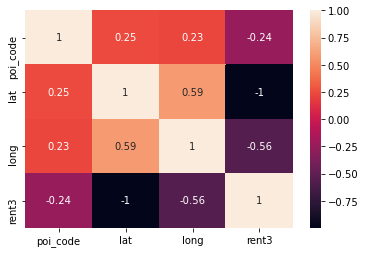

In [ ]:
sns.heatmap(df_mumbai.corr(),annot=True)

In [ ]:
le=LabelEncoder()

In [ ]:
df_mumbai['indexing']=le.fit_transform(df_mumbai['col3'])

### We can see that the indexing is done where serially they are placed nearby and hexagons 
#### We can infere that more the index of a particular type more is its population.

In [ ]:
df_mumbai['indexing']

36364       0
36365       0
36366       0
36367       0
40698       1
         ... 
31455    2189
31456    2189
31457    2189
31458    2189
31459    2189
Name: indexing, Length: 12513, dtype: int32

### Cluster1 with index 50
#### if any cluster has value count of index of perticular value we can also classify the index as highly populated, medium populated and least populated

In [ ]:
cluster1=df_mumbai.loc[df_mumbai['indexing']==50]

In [ ]:
cluster1['poi_type'].isna().sum()

249

In [ ]:
cluster={}

In [ ]:
for i in range(2191):
    cluster[i]=pd.DataFrame(columns=df_mumbai.columns)
    cluster[i]=cluster[i].append(df_mumbai.loc[df_mumbai['indexing']==i])       

In [ ]:
cluster[2189]

,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,col3,House_rent,rent3,indexing
31454,3.981414e+09,Sanjay Nagar I,NaN,19.065753,72.926869,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff,,70589.755938,2189
31455,3.981414e+09,Sanjay Nagar II,NaN,19.067394,72.927457,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff,,70589.302302,2189
31456,5.913278e+09,Nirankari Nagar,NaN,19.067487,72.926157,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff,,70589.240292,2189
31457,3.204191e+09,NaN,shop.supermarket,19.066281,72.928428,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff,,70589.647494,2189
31458,3.205936e+09,rehmaan restaurant,food.restaurant,19.066293,72.927614,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff,,70589.621840,2189
31459,3.205936e+09,mahaveer hospital,health.hospital.general,19.067753,72.927593,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b56eb7ffff,,70589.203438,2189


### Now finding the poi_types in a particular cluster

In [ ]:
cluster[60]

,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,col3,House_rent,rent3,indexing
34538,7.577822e+09,NaN,travel.attraction.artwork,18.969546,72.819014,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01617ffff,,70614.357879,60
34539,7.411178e+09,Education Inspector South,facility.education.school,18.967596,72.818519,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01617ffff,,70614.902420,60
34540,7.411178e+09,Navneet Education Society Night Degree College,facility.education.college,18.968747,72.819013,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01617ffff,,70614.586369,60
34541,7.411178e+09,Gilder Lane Muncipal School,facility.education.school,18.968479,72.818972,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01617ffff,,70614.662002,60
34542,6.187955e+08,Fish market,NaN,18.969023,72.817232,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01617ffff,,70614.458902,60
34543,2.630075e+09,Mumbai Central,NaN,18.969586,72.819315,NaN,Mumbai,Maharashtra,India,NaN,NaN,89608b01617ffff,,70614.354674,60


In [ ]:
x=cluster[30]['poi_type'].values

In [ ]:
x=pd.Series(x)

In [ ]:
x=x.dropna()

In [ ]:
x=pd.DataFrame(x)

In [ ]:
x=x[0].str.split('.', expand=True)

In [ ]:
x2=x[[0,1]].copy()

In [ ]:
index = pd.MultiIndex.from_frame(x2,names=[0,1])

In [ ]:
x3=pd.DataFrame(x[2],index=index)

In [ ]:
x3

2
0        1                 
travel   accommodation  NaN
food     restaurant     NaN
         restaurant     NaN
facility education      NaN
service  finance        NaN
         finance        NaN
         finance        NaN

### The commercial area has the following features:
Arena,
Auditorium,
Bank
,Chain store
,Gas station
,Grocery store
,Hotel
,Movie theater
,Office
,Pharmacy
,Restaurant
,Shophouse
,Shopping mall
,Car Dealer
,Discount stores
,Warehouse clubs

### The residential area has teh following features:
Grocery store , parkings, walking area

In [ ]:
def cluster_info(cluster):
    x=cluster['poi_type']
    x=pd.DataFrame(x)
    x=x.dropna()
    x=x['poi_type'].str.split('.', expand=True)
    x2=x[[0,1]].copy()
    index2 = pd.MultiIndex.from_frame(x2,names=[0,1])
    x3=pd.DataFrame(x[2],index=index2)
    return x3

In [ ]:
y=cluster_info(cluster[40])

In [ ]:
def cluster_info2(cluster):
    x=cluster['poi_type']
    x=pd.DataFrame(x)
    x=x.dropna()
    x=x['poi_type'].str.split('.', expand=True)
    return x

In [ ]:
k=cluster_info2(cluster[40])

In [ ]:
print(k)

              0          1        2
30056    health   hospital  general
30059  facility  education   school


## By creating a function that will add 3-4 clusters and then by analyzing their poi_type we can classify the area as residential and Commercial
### > The function will take poi_types of all clusters and combine them into a dataframe on which we'll consider facilities, services, transportation, temple, parking and hence classify them 

In [ ]:
def classify(cluster):
    
    
    

In [ ]:
for i in range(2190):
    print('\n')
    print("Cluster Index=",i)
    print(cluster_info2(cluster[i]))



Cluster Index= 0
               0        1     2
36365    service  finance   atm
36366    service  finance  bank
36367  transport     fuel  None


Cluster Index= 1
Empty DataFrame
Columns: []
Index: []


Cluster Index= 2
            0         1            2
6461  service   amenity  photography
6462   health  hospital      general


Cluster Index= 3
Empty DataFrame
Columns: []
Index: []


Cluster Index= 4
              0          1         2
32884  facility  community  restroom


Cluster Index= 5
             0        1    2
32834  service  finance  atm
32835  service  finance  atm


Cluster Index= 6
Empty DataFrame
Columns: []
Index: []


Cluster Index= 7
              0          1         2
40580  facility  community  restroom


Cluster Index= 8
              0           1             2
11195    travel  attraction      landmark
11196    travel  attraction      landmark
11200  facility   community      restroom
11201   leisure     outdoor  scenic_point


Cluster Index= 9
Empty DataFr

               0       1
11974     health  clinic
11976  transport    fuel


Cluster Index= 67
              0           1          2
13585    health      clinic       None
13602  facility   education     school
13603  facility   education    college
13604      food  restaurant  fast_food
13605      food  restaurant       None
13606    health    hospital    general
13607  facility   education     school
13608  facility   education    college


Cluster Index= 68
Empty DataFrame
Columns: []
Index: []


Cluster Index= 69
             0        1             2
16793  leisure  outdoor  scenic_point


Cluster Index= 70
          0           1
33262  food  restaurant


Cluster Index= 71
Empty DataFrame
Columns: []
Index: []


Cluster Index= 72
Empty DataFrame
Columns: []
Index: []


Cluster Index= 73
              0           1          2
33184      food  restaurant  fast_food
33186  facility   education    college


Cluster Index= 74
             0            1          2
682       food   res

Index: []


Cluster Index= 138
Empty DataFrame
Columns: []
Index: []


Cluster Index= 139
            0           1          2
11208  travel  attraction   landmark
11209    food  restaurant  fast_food


Cluster Index= 140
            0       1
16679  health  clinic


Cluster Index= 141
Empty DataFrame
Columns: []
Index: []


Cluster Index= 142
              0           1          2
35052      food  restaurant       cafe
35053  facility   education    college
35054  facility   education     school
35056      food  restaurant  fast_food


Cluster Index= 143
             0              1          2
12566   health       hospital    general
12567  service        finance        atm
12568  service        finance        atm
12569   travel        service      agent
12570     food     restaurant       None
12571     food     restaurant       None
12572     food     restaurant       None
12575     food     restaurant  fast_food
12576     food     restaurant       None
12579     food     restauran

            0              1          2
39589  travel     attraction   landmark
39590  travel  accommodation  apartment
39591    food     restaurant       None


Cluster Index= 207
          0            1          2
14690  shop         home  furniture
14694  shop  supermarket       None
14695  shop      fashion       None


Cluster Index= 208
               0        1          2
41839       shop    hobby  bookstore
41840    leisure   indoor     cinema
41843  transport  parking       None
41844  transport  parking       None


Cluster Index= 209
            0              1            2
41911  travel  accommodation  guest_house
41912    food     restaurant         None


Cluster Index= 210
Empty DataFrame
Columns: []
Index: []


Cluster Index= 211
             0            1         2
35465   health     hospital   general
35466   health     hospital   general
35467     shop  electronics  consumer
35468  service      finance      bank
35469  service      finance      bank
35471  service

35047      shop  supermarket      convenience


Cluster Index= 274
             0         1        2
42717  service   finance     bank
42718   health  hospital  general


Cluster Index= 275
              0            1         2
6285     health     hospital   general
6286     health     hospital   general
6289    service      finance      bank
6291       shop  supermarket      None
6292    service      finance       atm
6293    service      finance      bank
6294    service      finance       atm
6296    service      finance      bank
6299  transport      parking      None
6300       shop  electronics  consumer
6302    service      finance      bank


Cluster Index= 276
              0          1         2
42615  facility  community  restroom


Cluster Index= 277
            0          1        2
42306  health     clinic  dentist
42307    shop  cosmetics   beauty
42308    shop  cosmetics   beauty


Cluster Index= 278
              0          1         2
13138    health   hospital   gen

2262      food   restaurant          None


Cluster Index= 332
              0            1            2
29944    health       clinic         None
29945  facility    education       school
29946    health     hospital      general
29947      shop      fashion         None
29949      shop  supermarket  convenience
29950      food   restaurant         None
29952      shop        hobby    bookstore
29953      shop  supermarket  convenience
29954      shop      fashion      jewelry
29956   service      finance         bank
29959      shop      fashion         None
29960      shop        hobby    bookstore
29961      food    nightlife      bar_pub
29964   service      finance         bank
29965      shop    cosmetics         hair
29968      shop  supermarket  convenience
29969      shop         home          diy
29970      shop  supermarket  convenience
29976   service      finance         bank
29979   service      finance         bank


Cluster Index= 333
            0            1        

30450  auto  car  dealership


Cluster Index= 392
              0           1             2
13219    health      clinic          None
13220      food  restaurant     fast_food
13221      food  restaurant     fast_food
13222      shop     fashion       jewelry
13223    health     service       optical
13224   service     finance           atm
13225  facility       event  banquet_hall
13227      food  restaurant          None


Cluster Index= 393
Empty DataFrame
Columns: []
Index: []


Cluster Index= 394
          0           1
13677  food  restaurant


Cluster Index= 395
              0          1         2
16656  facility  community  restroom


Cluster Index= 396
               0         1        2
33256     health  hospital  general
33258  transport      fuel     None


Cluster Index= 397
            0              1      2
40799  travel  accommodation  hotel


Cluster Index= 398
Empty DataFrame
Columns: []
Index: []


Cluster Index= 399
              0          1             2
12996 

10883    shop  electronics  consumer


Cluster Index= 521
Empty DataFrame
Columns: []
Index: []


Cluster Index= 522
            0       1          2
42217  health  clinic  physician


Cluster Index= 523
            0           1        2
13214  health    hospital  general
13215    food  restaurant     cafe
13217    shop    occasion  florist


Cluster Index= 524
              0           1            2
10655      food  restaurant         None
10656      food  restaurant    fast_food
10658      food  restaurant         None
10661      food  restaurant         None
10662      food  restaurant         None
10663      food  restaurant         None
10664      food  restaurant    fast_food
10666  facility   education       school
10667      shop        food  greengrocer


Cluster Index= 525
          0           1
38601  food  restaurant


Cluster Index= 526
             0        1     2
13536   health   clinic  None
13537   health   clinic  None
13538  service  finance  bank
13540  service 

Empty DataFrame
Columns: []
Index: []


Cluster Index= 636
Empty DataFrame
Columns: []
Index: []


Cluster Index= 637
Empty DataFrame
Columns: []
Index: []


Cluster Index= 638
             0        1     2
30470  service  finance  bank


Cluster Index= 639
Empty DataFrame
Columns: []
Index: []


Cluster Index= 640
             0              1       2
26190   travel  accommodation   hotel
26191   health      wellbeing  center
26192  service        finance     atm
26193   travel  accommodation   hotel


Cluster Index= 641
Empty DataFrame
Columns: []
Index: []


Cluster Index= 642
          0           1          2
26588  food  restaurant  fast_food


Cluster Index= 643
             0        1     2
40720  leisure  outdoor  park


Cluster Index= 644
            0       1
13208  health  clinic


Cluster Index= 645
            0         1        2
39224  health  hospital  general


Cluster Index= 646
Empty DataFrame
Columns: []
Index: []


Cluster Index= 647
              0            1  

3117  travel  service  agent


Cluster Index= 716
Empty DataFrame
Columns: []
Index: []


Cluster Index= 717
            0              1      2
40653  travel  accommodation  hotel


Cluster Index= 718
            0              1          2
30012  health       hospital    general
30013  travel  accommodation  apartment


Cluster Index= 719
Empty DataFrame
Columns: []
Index: []


Cluster Index= 720
Empty DataFrame
Columns: []
Index: []


Cluster Index= 721
            0          1           2
40167  health  wellbeing  playground


Cluster Index= 722
Empty DataFrame
Columns: []
Index: []


Cluster Index= 723
            0         1        2
12890  health  hospital  general


Cluster Index= 724
Empty DataFrame
Columns: []
Index: []


Cluster Index= 725
              0           1       2
36455  building  commercial  office


Cluster Index= 726
Empty DataFrame
Columns: []
Index: []


Cluster Index= 727
            0         1        2
13557  health  hospital  general


Cluster Index= 728


Empty DataFrame
Columns: []
Index: []


Cluster Index= 868
Empty DataFrame
Columns: []
Index: []


Cluster Index= 869
             0        1     2
37733  service  finance  bank


Cluster Index= 870
Empty DataFrame
Columns: []
Index: []


Cluster Index= 871
            0         1        2
30243  health  hospital  general


Cluster Index= 872
Empty DataFrame
Columns: []
Index: []


Cluster Index= 873
           0              1        2
6452  health         clinic     None
6454  travel  accommodation   hostel
6455  health       hospital  general
6456  health       hospital  general


Cluster Index= 874
           0         1        2
6450  health  hospital  general


Cluster Index= 875
Empty DataFrame
Columns: []
Index: []


Cluster Index= 876
            0         1        2
38693  health  hospital  general


Cluster Index= 877
               0     1
40820  transport  fuel


Cluster Index= 878
          0           1     2
42329  food  restaurant  cafe


Cluster Index= 879
           

41577  service  finance  bank


Cluster Index= 1004
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1005
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1006
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1007
            0         1        2
38695  health  hospital  general


Cluster Index= 1008
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1009
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1010
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1011
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1012
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1013
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1014
            0           1         2
11251  travel  attraction  landmark


Cluster Index= 1015
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1016
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1017
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1018
          0          1        2
41219  food  n

            0         1        2
12772  health    clinic     None
12773  health  hospital  general
12774  health  hospital  general


Cluster Index= 1139
            0         1        2
13086  health  hospital  general


Cluster Index= 1140
               0            1           2
13373     health     hospital     general
13374     health       clinic        None
13375     health     hospital     general
13376  transport      parking        None
13378     health     hospital     general
13379       shop  supermarket  department


Cluster Index= 1141
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1142
            0         1        2
38675  health  hospital  general
38677  health  hospital  general


Cluster Index= 1143
              0          1       2
13299    health     clinic    None
13300  facility  education  school


Cluster Index= 1144
              0            1        2
29764    health     hospital  general
29767  facility    education   school
29768  facility    e

Index: []


Cluster Index= 1251
            0         1        2
12555  health  hospital  general
12556  health    clinic     None


Cluster Index= 1252
             0         1        2
39233   health  hospital  general
39234  service   finance      atm


Cluster Index= 1253
             0        1     2
40047  leisure  outdoor  park


Cluster Index= 1254
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1255
              0          1       2
29808    health     clinic    None
29809   service    finance     atm
29810  facility  education  school
29811  facility  education  school


Cluster Index= 1256
            0         1        2
29816  health  hospital  general


Cluster Index= 1257
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1258
              0          1       2
41209  facility  education  school


Cluster Index= 1259
             0              1      2
28133  service        finance   bank
28134   travel  accommodation  hotel
28135  service        finance   b

Index: []


Cluster Index= 1352
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1353
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1354
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1355
            0       1
29843  health  clinic


Cluster Index= 1356
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1357
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1358
            0           1        2
12982  health    hospital  general
12983  health    hospital  general
12984  health    hospital  general
12985  health    hospital  general
12986  health    hospital  general
12987    food  restaurant     None
12988  health    hospital  general


Cluster Index= 1359
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1360
            0         1        2
38711  health  hospital  general
38712  health  hospital  general


Cluster Index= 1361
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1362
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1363

38079     food  restaurant       cafe


Cluster Index= 1463
             0        1     2
25654  service  finance  bank


Cluster Index= 1464
             0            1           2
27538     shop    cosmetics       store
27539  service      finance        bank
27540     shop         food       sweet
27541   health    wellbeing         gym
27542     food   restaurant        None
27543   health    wellbeing  playground
27544  leisure       indoor      cinema
27545     food   restaurant   fast_food
27546  service      finance        bank
27547     shop        habit     alcohol
27548     shop  supermarket        None


Cluster Index= 1465
             0        1     2
33816  service  finance  bank
33817  service  finance  bank
33818  service  finance  bank
33819  service  finance  bank
33821  service  finance  bank
33822  leisure  outdoor  park
33823   health   clinic  None


Cluster Index= 1466
             0            1     2
42153  service      finance   atm
42154  service      financ

10859  facility  education  school


Cluster Index= 1577
            0            1        2
30014  health     hospital  general
30016    shop  supermarket     None


Cluster Index= 1578
              0            1           2
4507   facility    community    restroom
4508       food   restaurant        cafe
4510   facility    education      school
4511   facility    community     library
4512   facility    community     library
4517     travel   attraction     artwork
4518     travel   attraction     artwork
4519     travel   attraction     artwork
4526  transport      parking     bicycle
4527  transport      parking     bicycle
4528  transport      parking     bicycle
4541       shop  supermarket  department
4550   facility    community    restroom
4551   facility    community    restroom
4552   facility    community    restroom
4553   facility    community    restroom
4554   facility    community    restroom
4555       shop         food  tea_coffee
4556       food   restaurant   fas

13548  health  clinic


Cluster Index= 1619
          0            1
35050  shop  supermarket


Cluster Index= 1620
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1621
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1622
            0              1      2
29841  health         clinic   None
29842  travel  accommodation  hotel


Cluster Index= 1623
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1624
            0           1           2
37134    food  restaurant  food_court
37135    food  restaurant        None
37136    food  restaurant   fast_food
37137  health    hospital     general


Cluster Index= 1625
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1626
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1627
            0         1        2
12105  health  hospital  general
12106  health    clinic     None


Cluster Index= 1628
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1629
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1630
E

29896  health  hospital  general


Cluster Index= 1733
              0              1        2
12775    health       hospital  general
12776    health       hospital  general
12777    travel  accommodation    hotel
12778    travel  accommodation   hostel
12779  facility      education   school


Cluster Index= 1734
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1735
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1736
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1737
             0          1     2
37411     shop  cosmetics  hair
37412  service    finance  bank


Cluster Index= 1738
          0           1          2
42557  food  restaurant  fast_food
42558  food  restaurant  fast_food


Cluster Index= 1739
          0          1        2
42282  food  nightlife  bar_pub


Cluster Index= 1740
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1741
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1742
          0            1
42287  shop  supermarket




28851    health    hospital    general


Cluster Index= 1839
              0           1          2
11987    health    hospital    general
11988  facility   community   restroom
11990  facility   community   restroom
11992      food  restaurant       cafe
11994      food  restaurant  fast_food
11995      shop   cosmetics     beauty
12001      food  restaurant  fast_food
12002      food  restaurant       None


Cluster Index= 1840
            0           1         2
27502  travel  attraction  landmark


Cluster Index= 1841
           0           1         2
5775  health      clinic      None
5776  health    hospital   general
5777  health      clinic      None
5778  health    hospital   general
5779    food  restaurant      None
5780    auto     bicycle      None
5781    auto     bicycle      None
5783  health     service  pharmacy
5785  health    hospital   general
5786    food  restaurant      None
5787  health    hospital   general
5788    shop        food     sweet
5789  health    h

27027  service  finance  bank


Cluster Index= 1891
             0        1        2
37029  leisure   indoor  theatre
37030     shop  fashion  jewelry


Cluster Index= 1892
               0          1       2
36567   facility  community  center
36570  transport       fuel    None


Cluster Index= 1893
            0         1        2
38722  health  hospital  general


Cluster Index= 1894
              0            1         2
27047  facility    community  restroom
27048      shop  electronics  consumer
27049    health     hospital   general


Cluster Index= 1895
              0            1         2
27044  facility    community  restroom
27046      shop  supermarket      None


Cluster Index= 1896
            0           1        2
31966    food  restaurant     None
31967  health    hospital  general
31968  health    hospital  general


Cluster Index= 1897
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1898
Empty DataFrame
Columns: []
Index: []


Cluster Index= 1899
          

12925    food  restaurant     cafe


Cluster Index= 1997
             0            1           2
11911   health       clinic        None
11912  service      finance        bank
11913  service      finance        bank
11914     shop         home    hardware
11915     shop    cosmetics        hair
11916     shop         home    hardware
11917     shop         food      bakery
11918     shop         food   ice_cream
11919  service      finance        bank
11920     shop  supermarket  department
11921     food   restaurant   fast_food
11922     shop     occasion       gifts


Cluster Index= 1998
            0           1          2
35297    food  restaurant       None
35298  health    hospital    general
35299    food  restaurant       cafe
35300    shop        food  ice_cream


Cluster Index= 1999
Empty DataFrame
Columns: []
Index: []


Cluster Index= 2000
            0           1          2
19001    food  restaurant  fast_food
19003  health      clinic       None


Cluster Index= 2001
 

35008  travel  accommodation  hotel


Cluster Index= 2057
            0         1        2
12543  health  hospital  general
12545  health    clinic     None


Cluster Index= 2058
             0          1        2
11933   health   hospital  general
11934   health   hospital  general
11935   health     clinic     None
11936   health   hospital  general
11937   health   hospital  general
11939  service    finance     bank
11940  service    finance     bank
11941     shop  cosmetics   beauty
11942   health  wellbeing   sports
11944  service    finance     bank


Cluster Index= 2059
            0           1          2
30039  health    hospital    general
30046    shop    occasion      gifts
30047    food  restaurant       cafe
30051  health      clinic  physician


Cluster Index= 2060
Empty DataFrame
Columns: []
Index: []


Cluster Index= 2061
Empty DataFrame
Columns: []
Index: []


Cluster Index= 2062
              0           1         2
12359    health      clinic      None
12360    he

42331  shop  fashion  jewelry


Cluster Index= 2168
          0            1
35058  shop  supermarket


Cluster Index= 2169
            0            1          2
35186    food   restaurant  fast_food
35187    food   restaurant  fast_food
35188    shop         food  ice_cream
35194  health       clinic       None
35195    shop  supermarket       None


Cluster Index= 2170
Empty DataFrame
Columns: []
Index: []


Cluster Index= 2171
              0           1       2
39853    health      clinic    None
39854   service     finance    bank
39855      food  restaurant    cafe
39856  facility   education  school


Cluster Index= 2172
              0          1       2
38260  facility  education  school


Cluster Index= 2173
            0         1          2
13517  health  hospital    general
13518    shop      food      sweet
13519    shop      food  ice_cream


Cluster Index= 2174
Empty DataFrame
Columns: []
Index: []


Cluster Index= 2175
          0            1            2
42321  shop 